In [6]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
from esem import gp_model
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

2024-03-04 22:20:30.746252: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 22:20:30.746325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 22:20:30.747255: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-04 22:20:30.753071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 22:20:31.619608: W tensorflow/compiler/tf2

### Prepare data

In [7]:
# List of dataset to use for training
train_files = ["ssp126", "ssp370", "ssp585", "historical", "hist-GHG"]

In [8]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(train_files)
y_train_tas = create_predictdand_data(train_files)['tas'].values.reshape(-1, 96 * 144)

X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
tas_truth = Y_test["tas"].mean('member')

In [9]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_tas = y_train_tas[~nan_train_mask]
assert len(X_train) == len(y_train_tas)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
tas_truth = tas_truth[~nan_test_mask]

In [10]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [11]:
# Standardize predictand fields
train_tas_mean, train_tas_std = y_train_tas.mean(), y_train_tas.std()
y_train_tas = (y_train_tas - train_tas_mean) / train_tas_std

### Prepare model Baseline

In [12]:
import gpflow
from gpflow.utilities import to_default_float
from gpflow.optimizers import Scipy
from gpflow.mean_functions import Constant
from gpflow.kernels import Matern52
from gpflow.utilities import print_summary

In [13]:
def create_feature_extractor(input_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='linear'),
        tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float64))
    ])
    return model


In [14]:
class DeepKernel(gpflow.kernels.Kernel):
    def __init__(self, feature_extractor, base_kernel, input_dim):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.base_kernel = base_kernel
        self.input_dim = input_dim

    def K(self, X, X2=None):
        # Transform X and X2 using the neural network
        X_transformed = self.feature_extractor(X)
        X2_transformed = self.feature_extractor(X2) if X2 is not None else X2
        # Compute the kernel using the transformed inputs
        return self.base_kernel(X_transformed, X2_transformed)

    def K_diag(self, X):
        X_transformed = self.feature_extractor(X)
        return self.base_kernel.K_diag(X_transformed)


In [15]:
# Define the neural network feature extractor
input_dim = X_train.shape[1]  # Number of features in X
output_dim = 24
feature_extractor = create_feature_extractor(input_dim, output_dim)

# Freeze the neural network layers to make them non-trainable in GPflow's optimization process
for layer in feature_extractor.layers:
    layer.trainable = True

# Define the base kernel and the deep kernel
kernel_CO2 = Matern52(active_dims=[0, 1], variance=1.0, lengthscales=2 * [1.])
kernel_CH4 = Matern52(active_dims=[2, 3], variance=1.0, lengthscales=2 * [1.])
kernel_BC = Matern52(active_dims=[4, 5, 6, 7, 8, 9, 10, 11, 12, 13], variance=1.0, lengthscales=10 * [1.])
kernel_SO2 = Matern52(active_dims=[14, 15, 16, 17, 18, 19, 20, 21, 22, 23], variance=1.0, lengthscales=10 * [1.])

kernel_matern12 = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

base_kernel = kernel_matern12
deep_kernel = DeepKernel(feature_extractor=feature_extractor, base_kernel=base_kernel, input_dim=input_dim)

# Mean Function
mean_function = Constant()

# Create the GP model
model = gpflow.models.GPR(data=(X_train.astype(float), y_train_tas.astype(float)), kernel=deep_kernel, mean_function=mean_function)

# Compile the TensorFlow model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def optimization_step():
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        loss = -model.log_marginal_likelihood()
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

2024-03-04 22:20:40.735050: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79084 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


In [16]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:
tolerance = 1e-6  # Define tolerance
patience = 10  # Define patience

# Initialize variables for early stopping mechanism
best_loss = float('inf')
patience_counter = 0
max_iterations = 5000

# Training loop
for iteration in range(max_iterations):  # Number of optimization steps
    loss = optimization_step()

    # Early stopping logic
    if best_loss - loss < tolerance:
        patience_counter += 1
    else:
        patience_counter = 0
        best_loss = loss

    if patience_counter >= patience:
        print(f"Stopping training after {iteration + 1} iterations due to convergence.")
        break

2024-03-04 22:20:48.466396: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0xb06d1d0
2024-03-04 22:20:48.557974: I external/local_xla/xla/service/service.cc:168] XLA service 0x14440c389cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-04 22:20:48.558019: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-03-04 22:20:48.562951: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-04 22:20:48.582126: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1709616048.717748  201596 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Stopping training after 360 iterations due to convergence.


### Predict on testing set

In [18]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_tas_std + train_tas_mean
posterior_std = np.sqrt(standard_posterior_var) * train_tas_std

In [19]:
# put output back into xarray format for calculating RMSE/plotting
posterior_tas = np.reshape(posterior_mean, [86, 96, 144])
posterior_tas_std = np.reshape(posterior_std, [86, 96, 144])

posterior_tas_data = xr.DataArray(posterior_tas, dims=tas_truth.dims, coords=tas_truth.coords)
posterior_tas_std_data = xr.DataArray(posterior_tas_std, dims=tas_truth.dims, coords=tas_truth.coords)

In [20]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(tas_truth[35], posterior_tas_data[35])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[85], posterior_tas_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[30:41], posterior_tas_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[75:], posterior_tas_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], posterior_tas_data[35:]).mean()}")

RMSE at 2050: 0.41033423677301145
RMSE at 2100: 0.8697709304621625
RMSE 2045-2055: 0.45113806492488384
RMSE 2090-2100: 0.886856965315535
RMSE 2050-2100: 0.6323018029066488


[Text(0.5, 1.0, 'Difference')]

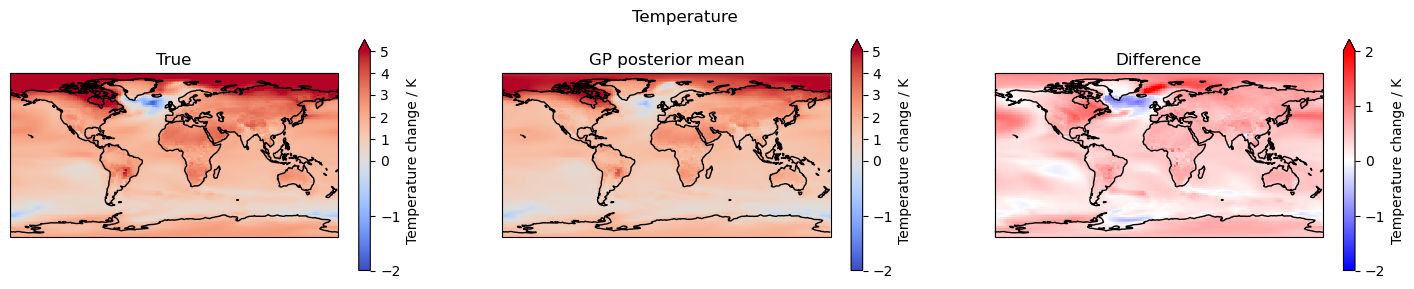

In [21]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
tas_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_tas_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = tas_truth - posterior_tas_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [22]:
def global_mean(ds):
    if 'lat' not in ds.coords:
        ds_ = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    else:
        ds_ = ds
    weights = np.cos(np.deg2rad(ds_.lat))
    return ds_.weighted(weights).mean(['lat', 'lon'])

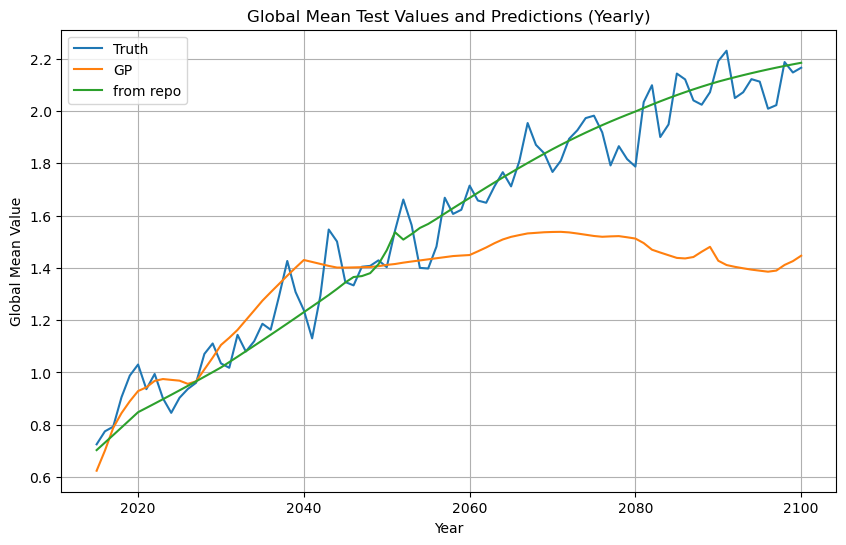

In [23]:
t = xr.open_dataarray('climatebench-gp-posterior-mean-tas-test-2019-2100.nc')
plt.figure(figsize=(10, 6))
global_mean(tas_truth).plot(label="Truth")
global_mean(posterior_tas_data).plot(label='GP')
global_mean(t).plot(label='from repo')
plt.title('Global Mean Test Values and Predictions (Yearly)')
plt.ylabel('Global Mean Value')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

## Hyperparams Tuning

In [24]:
from ray import tune, train
from ray.tune.search.hyperopt import HyperOptSearch
from gpflow.kernels import Matern12, Matern32, Matern52, SquaredExponential, RationalQuadratic, Cosine, Periodic, Polynomial, ArcCosine, Exponential
import keras
import math
from gpflow.mean_functions import Constant
from xskillscore import rmse
from ray.tune import CLIReporter
import ray
import multiprocessing as mp
import os

In [25]:
ray.init(num_cpus=1, num_gpus=1)

2024-03-04 22:21:00,312	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.9.18
Ray version:,2.9.3


In [26]:
def get_rmse(truth, pred):
    return np.sqrt(((truth-pred)**2))

def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).mean(['lat', 'lon'])

def global_sum(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).sum(['lat', 'lon'])

weights = np.cos(np.deg2rad(tas_truth.lat)).expand_dims(lon=144).assign_coords(lon=tas_truth.lon)
    
def TNRMSE(truth, pred, Yearslice=slice(2080, None)):
    # R2E Score
    R2E = rmse(
        global_mean(truth.sel(time=Yearslice)), 
        global_mean(pred.sel(time=Yearslice))
    ).data/np.abs(global_mean(tas_truth.sel(time=Yearslice).mean('time')).data)

    # NRMSE score
    NRMSE = rmse(
        truth.sel(time=Yearslice).mean('time'), 
        pred.sel(time=Yearslice).mean('time'), weights=weights
    ).data/ np.abs(global_mean(truth.sel(time=Yearslice).mean('time')).data)

    total = (NRMSE + 5*R2E).T.round(3)
    return total

In [27]:
def make_feature_extractor(dim_max, activation, input_dim, output_dim, dropout_prob, bnorm=True, dropout=True):
    model = tf.keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(input_dim,)))
    
    dimensions = [dim_max // (2 ** i) for i in range(int(math.log(dim_max, 2)) + 1) if dim_max // (2 ** i) > input_dim]

    for dim in dimensions[::-1]:
        model.add(keras.layers.Dense(dim, activation=activation))
        if bnorm:
            model.add(keras.layers.BatchNormalization())
        if dropout:
            model.add(keras.layers.Dropout(dropout_prob))

    for dim in dimensions:
        if dim <= output_dim:
            break
        model.add(keras.layers.Dense(dim, activation=activation))
        if bnorm:
            model.add(keras.layers.BatchNormalization())
        if dropout:
            model.add(keras.layers.Dropout(dropout_prob))

    model.add(keras.layers.Dense(output_dim, activation='linear'))
    model.add(keras.layers.Lambda(lambda x: tf.cast(x, tf.float64)))
        
    return model

In [28]:
def basekernel(kernel_types, active_dim_multiplier, variance=1.0, lengthscales=1.0):
    kernels = {
        'Matern12': Matern12, 'Matern32': Matern32, 'Matern52': Matern52, 'SquaredExponential': SquaredExponential, 'RationalQuadratic': RationalQuadratic, 'Cosine':Cosine, 'Periodic': Periodic,
        'Polynomial': Polynomial, 'ArcCosine': ArcCosine, 'Exponential': Exponential
    }
    dims = [x for x in range(12*active_dim_multiplier)]
    def CO2(kernel):
        active_dims = dims[0:active_dim_multiplier*1]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(1*active_dim_multiplier) * [1.])
        return k

    def CH4(kernel):
        active_dims = dims[1*active_dim_multiplier:active_dim_multiplier*2]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(1*active_dim_multiplier) * [1.])
        return k
        
    def BC(kernel):
        active_dims = dims[2*active_dim_multiplier:active_dim_multiplier*2 + 5*active_dim_multiplier]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(5*active_dim_multiplier) * [1.])
        return k

    def SO2(kernel):
        active_dims = dims[active_dim_multiplier*2 + 5*active_dim_multiplier:]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(5*active_dim_multiplier) * [1.])
        return k
    
    kernel = CO2(kernels[kernel_types[0]]) + CH4(kernels[kernel_types[1]]) + BC(kernels[kernel_types[2]]) + SO2(kernels[kernel_types[3]])

    return kernel

In [29]:
def objective(config, return_pred=False):  # ①
    input_dim = X_train.shape[1]  # Number of features in X
    
    output_dim = config["output_dim"]
    # Feature extractor for deep kernel
    feature_extractor = make_feature_extractor(
        config["dim_max"], config["activation"], input_dim, config["output_dim"], config["dropout_prob"], bnorm=config["bnorm"], dropout=config["dropout"]
    )
    
    # Freeze the neural network layers to make them non-trainable in GPflow's optimization process
    for layer in feature_extractor.layers:
        layer.trainable = True
    
    # Define kernel
    base_kernel = basekernel(
        config["kernel_types"], config["active_dim_multiplier"]
    )
    deep_kernel = DeepKernel(feature_extractor=feature_extractor, base_kernel=base_kernel, input_dim=input_dim)

    mean_function = Constant() # Define Mean function

    optimizer  = tf.keras.optimizers.Adam(learning_rate=config["optimizer_lr"])# Define opt

    model = gpflow.models.GPR(data=(X_train.astype(float), y_train_tas.astype(float)), kernel=deep_kernel, mean_function=mean_function)
    

    # custom optimizer
    @tf.function
    def optimization_step():
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(model.trainable_variables)
            loss = -model.log_marginal_likelihood()
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss


    # Training
    tolerance, patience = 1e-6, 10  # Define tolerance and patience

    # Initialize variables for early stopping mechanism
    best_loss, patience_counter, max_iterations = float('inf'), 0, 5000
    
    # Training loop
    for iteration in range(max_iterations):  # Number of optimization steps
        loss = optimization_step()
    
        # Early stopping logic
        if best_loss - loss < tolerance:
            patience_counter += 1
        else:
            patience_counter = 0
            best_loss = loss
    
        if patience_counter >= patience:
            print(f"Stopping training after {iteration + 1} iterations due to convergence.")
            break

    # Eval
    standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
    posterior_mean = standard_posterior_mean * train_tas_std + train_tas_mean
    posterior_std = np.sqrt(standard_posterior_var) * train_tas_std

    # put output back into xarray format for calculating RMSE/plotting
    posterior_tas = np.reshape(posterior_mean, [86, 96, 144])
    posterior_tas_std = np.reshape(posterior_std, [86, 96, 144])
    
    posterior_tas_data = xr.DataArray(posterior_tas, dims=tas_truth.dims, coords=tas_truth.coords)
    posterior_tas_std_data = xr.DataArray(posterior_tas_std, dims=tas_truth.dims, coords=tas_truth.coords)

    total_NRMSE = TNRMSE(tas_truth, posterior_tas_data)

    if return_pred:
        return posterior_tas_data, posterior_tas_std_data


    return {'nrmse':total_NRMSE}

In [30]:
def run_tuner(search_space, num_samples=50):
    algo = HyperOptSearch()
    
    tuner = tune.Tuner(  # ③
        tune.with_resources(
            objective,
            resources={"gpu": 1}
        ),
        tune_config=tune.TuneConfig(
            metric="nrmse",
            mode="min",
            num_samples=num_samples,
            search_alg=algo,
        ),
        param_space=search_space,
    )

    results = tuner.fit()
    return results

In [31]:
search_space2 = {
        "activation": tune.choice(["relu", "tanh", 'sigmoid']), "bnorm": tune.choice([True, False]), "dropout": tune.choice([True, False]), 'dropout_prob': tune.choice([0.5]),
        "kernel_types": tune.choice([4*['Matern32'], 4*['Matern12'], 4*['Matern52']]), "active_dim_multiplier": tune.choice([1, 2]), "dim_max": tune.choice([128, 256, 512]), 
        "output_dim": tune.choice([36, 48, 60, 72, 84]), "optimizer_lr": tune.choice([0.01, 0.001, 0.0001])
    }  # ②

search_space1 = {
    "activation": tune.choice(["relu", "tanh", 'sigmoid']), "bnorm": tune.choice([True, False]), "dropout": tune.choice([True, False]), 'dropout_prob': tune.choice([0.5]),
    "kernel_types": tune.choice([4*['Matern32'], 4*['Matern12'], 4*['Matern52'], 4*['SquaredExponential']]), "active_dim_multiplier": tune.choice([1, 2]), "dim_max": tune.choice([128, 256, 64]), 
    "output_dim": tune.choice([12, 24, 36, 48, 60]), "optimizer_lr": tune.choice([0.01, 0.001])
}

run_tuner(search_space1)

(raylet) Warning: The actor ImplicitFunc is very large (35 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(pid=202417) 2024-03-04 22:21:03.855578: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=202417) 2024-03-04 22:21:03.855674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=202417) 2024-03-04 22:21:03.859167: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=202417) 2024-03-04 22:21:03.887992: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=202417) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

(objective pid=202417) Stopping training after 3001 iterations due to convergence.


(objective pid=202417) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x145427b611f0> and will run it as-is.
(objective pid=202417) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=202417) Cause: Unknown node type <gast.gast.Import object at 0x14541c072a30>
(objective pid=202417) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:21:55,747	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=202417) Stopping training after 365 iterations due to convergence.


(objective pid=202417) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1452effebd30> and will run it as-is.
(objective pid=202417) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=202417) Cause: Unknown node type <gast.gast.Import object at 0x145427bfe580>
(objective pid=202417) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:22:02,061	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=202417) Stopping training after 317 iterations due to convergence.


(objective pid=202417) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1452bc18ce50> and will run it as-is.
(objective pid=202417) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=202417) Cause: Unknown node type <gast.gast.Import object at 0x145278da0220>
(objective pid=202417) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:22:28,099	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=202417) Stopping training after 2380 iterations due to convergence.


(objective pid=202417) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x145427f40670> and will run it as-is.
(objective pid=202417) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=202417) Cause: Unknown node type <gast.gast.Import object at 0x14530066fd60>
(objective pid=202417) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:22:56,124	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=202417) Stopping training after 2530 iterations due to convergence.


(objective pid=202417) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1452effebca0> and will run it as-is.
(objective pid=202417) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=202417) Cause: Unknown node type <gast.gast.Import object at 0x14530083cca0>
(objective pid=202417) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:23:04,385	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=202417) Stopping training after 395 iterations due to convergence.


(objective pid=202417) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x145278cb9e50> and will run it as-is.
(objective pid=202417) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=202417) Cause: Unknown node type <gast.gast.Import object at 0x14521dd07be0>
(objective pid=202417) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:23:30,550	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=202417) Stopping training after 1983 iterations due to convergence.


(objective pid=202417) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14527825b5e0> and will run it as-is.
(objective pid=202417) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=202417) Cause: Unknown node type <gast.gast.Import object at 0x14521d55e7f0>
(objective pid=202417) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:23:55,124	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=202417) Stopping training after 2182 iterations due to convergence.


(objective pid=202417) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14527825bb80> and will run it as-is.
(objective pid=202417) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=202417) Cause: Unknown node type <gast.gast.Import object at 0x14521cf626d0>
(objective pid=202417) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=202417) 2024-03-04 22:24:08.519016: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 62.02MiB (rounded to 65028096)requested by op gradient_tape/Mul_1
(objective pid=202417) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=202417) Current allocation summary follows

(objective pid=203520) Stopping training after 421 iterations due to convergence.


(objective pid=203520) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14dcfde47af0> and will run it as-is.
(objective pid=203520) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=203520) Cause: Unknown node type <gast.gast.Import object at 0x14dbec219850>
(objective pid=203520) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:24:40,256	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=203520) Stopping training after 174 iterations due to convergence.


(objective pid=203520) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14dcfea12040> and will run it as-is.
(objective pid=203520) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=203520) Cause: Unknown node type <gast.gast.Import object at 0x14dbe00a1940>
(objective pid=203520) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:24:48,093	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=203520) Stopping training after 412 iterations due to convergence.


(objective pid=203520) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14dcfde47af0> and will run it as-is.
(objective pid=203520) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=203520) Cause: Unknown node type <gast.gast.Import object at 0x14dbc974d310>
(objective pid=203520) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:25:09,740	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=203520) Stopping training after 2071 iterations due to convergence.


(objective pid=203520) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14db5c924790> and will run it as-is.
(objective pid=203520) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=203520) Cause: Unknown node type <gast.gast.Import object at 0x14dbe00fed60>
(objective pid=203520) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:25:35,765	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=203520) Stopping training after 2294 iterations due to convergence.


(objective pid=203520) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14db5c9dfa60> and will run it as-is.
(objective pid=203520) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=203520) Cause: Unknown node type <gast.gast.Import object at 0x14db012c3310>
(objective pid=203520) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:26:08,987	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=203520) Stopping training after 2763 iterations due to convergence.


(objective pid=203520) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14dbe00b5280> and will run it as-is.
(objective pid=203520) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=203520) Cause: Unknown node type <gast.gast.Import object at 0x14dbe0126880>
(objective pid=203520) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:26:17,056	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=203520) Stopping training after 377 iterations due to convergence.


(objective pid=203520) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14db00cf1040> and will run it as-is.
(objective pid=203520) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=203520) Cause: Unknown node type <gast.gast.Import object at 0x14db010ceca0>
(objective pid=203520) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:26:26,102	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=203520) Stopping training after 357 iterations due to convergence.


(objective pid=203520) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14db00738e50> and will run it as-is.
(objective pid=203520) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=203520) Cause: Unknown node type <gast.gast.Import object at 0x14db005a4ca0>
(objective pid=203520) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=203520) 2024-03-04 22:26:39.145152: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 62.02MiB (rounded to 65028096)requested by op gradient_tape/Mul_1
(objective pid=203520) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=203520) Current allocation summary follows

(objective pid=204481) Stopping training after 2074 iterations due to convergence.


(objective pid=204481) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144f3819e5e0> and will run it as-is.
(objective pid=204481) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=204481) Cause: Unknown node type <gast.gast.Import object at 0x144e24103c10>
(objective pid=204481) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=204481) Stopping training after 3408 iterations due to convergence.


2024-03-04 22:27:55,709	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
(objective pid=204481) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144f3819e160> and will run it as-is.
(objective pid=204481) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=204481) Cause: Unknown node type <gast.gast.Import object at 0x144ddc0ab820>
(objective pid=204481) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:28:03,916	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=204481) Stopping training after 409 iterations due to convergence.


(objective pid=204481) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144f3819e160> and will run it as-is.
(objective pid=204481) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=204481) Cause: Unknown node type <gast.gast.Import object at 0x144d9d7feb50>
(objective pid=204481) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:28:27,414	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=204481) Stopping training after 2513 iterations due to convergence.


(objective pid=204481) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144d9d808040> and will run it as-is.
(objective pid=204481) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=204481) Cause: Unknown node type <gast.gast.Import object at 0x144d9d154c10>
(objective pid=204481) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:28:37,086	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=204481) Stopping training after 370 iterations due to convergence.


(objective pid=204481) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144d9d607550> and will run it as-is.
(objective pid=204481) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=204481) Cause: Unknown node type <gast.gast.Import object at 0x144d9cb15f40>
(objective pid=204481) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:28:45,455	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=204481) Stopping training after 323 iterations due to convergence.


(objective pid=204481) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144d9ca93430> and will run it as-is.
(objective pid=204481) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=204481) Cause: Unknown node type <gast.gast.Import object at 0x144d9cb11760>
(objective pid=204481) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:29:16,746	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=204481) Stopping training after 3246 iterations due to convergence.


(objective pid=204481) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144d9c62a8b0> and will run it as-is.
(objective pid=204481) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=204481) Cause: Unknown node type <gast.gast.Import object at 0x144d9d041fa0>
(objective pid=204481) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:29:24,258	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=204481) Stopping training after 396 iterations due to convergence.


(objective pid=204481) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144d9c084310> and will run it as-is.
(objective pid=204481) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=204481) Cause: Unknown node type <gast.gast.Import object at 0x144d9c4bd8b0>
(objective pid=204481) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=204481) 2024-03-04 22:29:36.284080: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 62.02MiB (rounded to 65028096)requested by op gradient_tape/Mul_1
(objective pid=204481) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=204481) Current allocation summary follows

(objective pid=205406) Stopping training after 2222 iterations due to convergence.


(objective pid=205406) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1513510e8160> and will run it as-is.
(objective pid=205406) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=205406) Cause: Unknown node type <gast.gast.Import object at 0x1512301d8e80>
(objective pid=205406) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:30:18,393	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=205406) Stopping training after 423 iterations due to convergence.


(objective pid=205406) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x151351172160> and will run it as-is.
(objective pid=205406) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=205406) Cause: Unknown node type <gast.gast.Import object at 0x1511ec14a370>
(objective pid=205406) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=205406) Stopping training after 349 iterations due to convergence.


2024-03-04 22:30:27,639	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
(objective pid=205406) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15121978faf0> and will run it as-is.
(objective pid=205406) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=205406) Cause: Unknown node type <gast.gast.Import object at 0x1511ec1ad040>
(objective pid=205406) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:30:56,759	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=205406) Stopping training after 3167 iterations due to convergence.


(objective pid=205406) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1512387ccee0> and will run it as-is.
(objective pid=205406) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=205406) Cause: Unknown node type <gast.gast.Import object at 0x1511a9d112e0>
(objective pid=205406) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:31:30,799	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=205406) Stopping training after 3011 iterations due to convergence.


(objective pid=205406) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x151219760700> and will run it as-is.
(objective pid=205406) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=205406) Cause: Unknown node type <gast.gast.Import object at 0x1511a98a02e0>
(objective pid=205406) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:31:37,594	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=205406) Stopping training after 288 iterations due to convergence.


(objective pid=205406) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1511d01c1e50> and will run it as-is.
(objective pid=205406) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=205406) Cause: Unknown node type <gast.gast.Import object at 0x1511a9148490>
(objective pid=205406) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:32:10,152	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=205406) Stopping training after 2957 iterations due to convergence.


(objective pid=205406) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1511a93741f0> and will run it as-is.
(objective pid=205406) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=205406) Cause: Unknown node type <gast.gast.Import object at 0x15135139ca60>
(objective pid=205406) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:32:17,192	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=205406) Stopping training after 327 iterations due to convergence.


(objective pid=205406) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1513510e83a0> and will run it as-is.
(objective pid=205406) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=205406) Cause: Unknown node type <gast.gast.Import object at 0x1511a8452e80>
(objective pid=205406) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=205406) 2024-03-04 22:32:30.262717: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 62.02MiB (rounded to 65028096)requested by op gradient_tape/Mul_1
(objective pid=205406) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=205406) Current allocation summary follows

(objective pid=206455) Stopping training after 403 iterations due to convergence.


(objective pid=206455) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14c1e41075e0> and will run it as-is.
(objective pid=206455) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=206455) Cause: Unknown node type <gast.gast.Import object at 0x14c0d01c0e20>
(objective pid=206455) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:33:11,261	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=206455) Stopping training after 355 iterations due to convergence.


(objective pid=206455) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14c1eef2e790> and will run it as-is.
(objective pid=206455) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=206455) Cause: Unknown node type <gast.gast.Import object at 0x14c048f81d90>
(objective pid=206455) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:33:17,212	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=206455) Stopping training after 184 iterations due to convergence.


(objective pid=206455) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14c1e41078b0> and will run it as-is.
(objective pid=206455) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=206455) Cause: Unknown node type <gast.gast.Import object at 0x14bfedda4f10>
(objective pid=206455) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:33:26,324	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=206455) Stopping training after 332 iterations due to convergence.


(objective pid=206455) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14c04874aca0> and will run it as-is.
(objective pid=206455) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=206455) Cause: Unknown node type <gast.gast.Import object at 0x14bfed72aa00>
(objective pid=206455) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:33:33,256	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=206455) Stopping training after 349 iterations due to convergence.


(objective pid=206455) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14c04874ab80> and will run it as-is.
(objective pid=206455) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=206455) Cause: Unknown node type <gast.gast.Import object at 0x14bfed1ca2b0>
(objective pid=206455) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:33:42,382	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=206455) Stopping training after 345 iterations due to convergence.


(objective pid=206455) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14c04874ab80> and will run it as-is.
(objective pid=206455) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=206455) Cause: Unknown node type <gast.gast.Import object at 0x14bfed1d4d00>
(objective pid=206455) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=206455) Stopping training after 294 iterations due to convergence.


2024-03-04 22:33:49,436	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
(objective pid=206455) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14c04874a670> and will run it as-is.
(objective pid=206455) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=206455) Cause: Unknown node type <gast.gast.Import object at 0x14bfed215d00>
(objective pid=206455) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=206455) 2024-03-04 22:34:01.520033: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 108.0KiB (rounded to 110592)requested by op Sum_4
(objective pid=206455) If the cause is

(objective pid=207257) Stopping training after 349 iterations due to convergence.


(objective pid=207257) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e52d3a7e50> and will run it as-is.
(objective pid=207257) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=207257) Cause: Unknown node type <gast.gast.Import object at 0x14e3fffd5520>
(objective pid=207257) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:34:31,323	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=207257) Stopping training after 377 iterations due to convergence.


(objective pid=207257) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e5241695e0> and will run it as-is.
(objective pid=207257) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=207257) Cause: Unknown node type <gast.gast.Import object at 0x14e41001bf40>
(objective pid=207257) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:34:36,679	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=207257) Stopping training after 138 iterations due to convergence.


(objective pid=207257) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e3cc12f040> and will run it as-is.
(objective pid=207257) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=207257) Cause: Unknown node type <gast.gast.Import object at 0x14e52c641f10>
(objective pid=207257) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:34:43,423	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=207257) Stopping training after 362 iterations due to convergence.


(objective pid=207257) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e41002ca60> and will run it as-is.
(objective pid=207257) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=207257) Cause: Unknown node type <gast.gast.Import object at 0x14e3283963a0>
(objective pid=207257) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:34:50,811	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=207257) Stopping training after 363 iterations due to convergence.


(objective pid=207257) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e3cc12f160> and will run it as-is.
(objective pid=207257) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=207257) Cause: Unknown node type <gast.gast.Import object at 0x14e309db95b0>
(objective pid=207257) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-04 22:34:58,458	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=207257) Stopping training after 374 iterations due to convergence.


2024-03-04 22:34:58,490	ERROR tune.py:1038 -- Trials did not complete: [objective_7e6602ba, objective_160980ed, objective_61568f61, objective_8b9ac83d, objective_64c8cc05]
2024-03-04 22:34:58,491	INFO tune.py:1042 -- Total run time: 836.94 seconds (836.72 seconds for the tuning loop).


ResultGrid<[
  Result(
    metrics={'nrmse': 2.721},
    path='/glade/u/home/jklim/ray_results/objective_2024-03-04_22-21-01/objective_59abfab1_1_activation=sigmoid,active_dim_multiplier=1,bnorm=True,dim_max=256,dropout=False,dropout_prob=0.5000,kernel_ty_2024-03-04_22-21-01',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'nrmse': 2.591},
    path='/glade/u/home/jklim/ray_results/objective_2024-03-04_22-21-01/objective_724000e2_2_activation=relu,active_dim_multiplier=1,bnorm=False,dim_max=64,dropout=False,dropout_prob=0.5000,kernel_types_2024-03-04_22-21-08',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'nrmse': 2.144},
    path='/glade/u/home/jklim/ray_results/objective_2024-03-04_22-21-01/objective_29738178_3_activation=relu,active_dim_multiplier=2,bnorm=False,dim_max=64,dropout=False,dropout_prob=0.5000,kernel_types_2024-03-04_22-21-49',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'nrmse': 0.454},
    p

In [32]:
result = _

In [64]:
best_config = result.get_best_result()
hyperparam_df = result.get_dataframe()
hyperparam_df_sorted = hyperparam_df.sort_values(by='nrmse')

In [ ]:
mean_best, std_best = objective(best_config.config, return_pred=True)

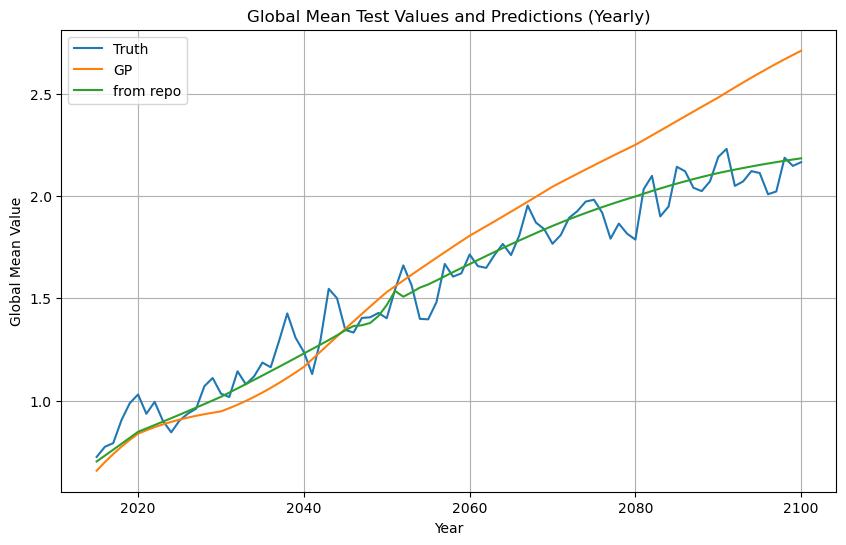

In [121]:
t = xr.open_dataarray('climatebench-gp-posterior-mean-tas-test-2019-2100.nc')
plt.figure(figsize=(10, 6))
global_mean(tas_truth).plot(label="Truth")
global_mean(mean_best).plot(label='GP')
global_mean(t).plot(label='from repo')
plt.title('Global Mean Test Values and Predictions (Yearly)')
plt.ylabel('Global Mean Value')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

[Text(0.5, 1.0, 'Difference')]

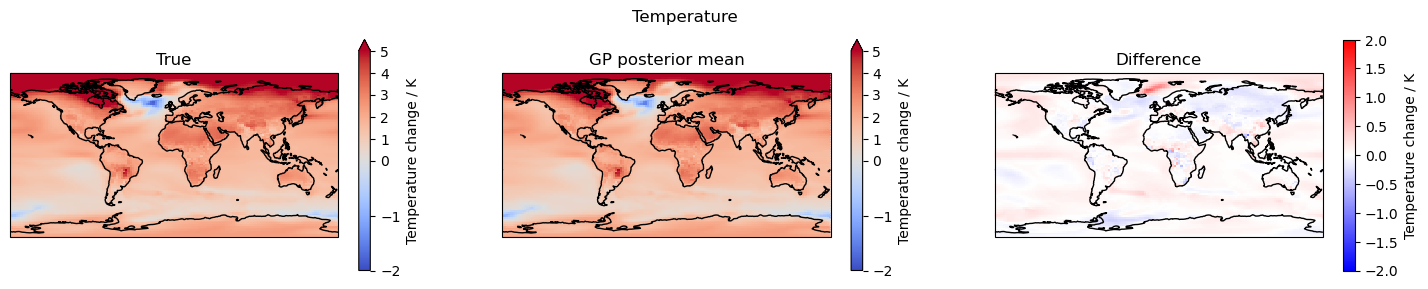

In [118]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
tas_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
mean_best.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = tas_truth - mean_best
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [119]:
mean_best.to_netcdf('results/Final-dkl-mean-tas-2.nc')
std_best.to_netcdf('results/Final-dkl-std-tas-2.nc')

## Best Config

- Kernel = Matern52
- Lr = 0.01
- Output_dim = 36
- Dropout_prob = 0.5
- Dropout = False
- Input_dim = 256
- bnorm = False
- Active Dim = 1
- Activation = Sigmoid